File to analyse our various results. 

In [2]:
# Packages needed for the script
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools


# matplotlib inline 
%matplotlib inline


In [3]:
# Set up plot style
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 20})
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['figure.figsize'] = (10, 6)

/var/folders/5n/dz64p0d10mbdprldq9m5sp08pnqwrk/T/ipykernel_48747/747729890.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Define a function to plot metric for each optimiser

In [5]:
def plot_optimizer_results(results_data, optimizer, metric='accuracy', metric_err='accuracy_std', 
    modeling_type = 'training', yaxisticks = [], flg_save=True):
    """
    Function to plot the results for a given optimizer.
    
    Parameters:
    - results_data: DataFrame containing the results data
    - optimizer: string, name of the optimizer to plot
    """
    # Filter the data for the specified optimizer
    optimizer_data = results_data[results_data['optimiser'] == optimizer]
    
    # Create custom x-axis labels with the combination of dropout and learning rate
    if modeling_type == 'training' or modeling_type == 'prediction':
        dropouts = [0.15, 0.2, 0.25]
        learning_rates = [0.0001, 0.0005, 0.005]
    elif modeling_type == 'finetuning' or modeling_type == 'finetune_prediction':
        dropouts = [0.15, 0.2, 0.25]
        learning_rates = [0.0001, 0.0005]
    else:
        raise ValueError("Invalid modeling type. Choose from 'training', 'finetuning', or 'prediction'.")
    # Create a list of combinations of learning rates and dropouts
    combinations = list(itertools.product(learning_rates, dropouts))
    x_labels = [f"({a}, {b})" for a, b in combinations]
    
    # Marker and color styles for each line
    # if modeling_type == 'training' or modeling_type == 'prediction':
    markers = ['o', 'D', '^']
    colours = ['blue', 'green', 'red']
    linestyles = ['-', '-.', ':']
    Labels = ['CH training only', 
        'CH and final layer unfrozen', 
        'CH and final two layers unfrozen']
    
    # Set the figure size
    plt.figure(figsize=(10, 6))
    
    # Set the title -- comment out for plot for the paper
    #plt.title(f'{optimizer} Optimiser')
    
    # Set the x and y axis labels
    plt.xlabel('(Learning Rate, Dropout Rate)')
    if metric == 'accuracy':   
        plt.ylabel('Accuracy')
    elif metric == 'tn':
        plt.ylabel('True Negatives')
    elif metric == 'tp':
        plt.ylabel('True Positives')
    elif metric == 'fn':
        plt.ylabel('False Negative Rate')
    elif metric == 'fp':
        plt.ylabel('False Positive Rate')
    elif metric == 'f1_score' or metric == 'weighted_avg_f1':
        plt.ylabel('F1 Score')
    elif metric == 'total_train_time_s' or metric == 'TrainingTimeSeconds':
        plt.ylabel('Total Train Time (s)')
    elif metric == 'TrainingTimeMin':
        plt.ylabel('Total Train Time (min)')
    elif metric == 'prediction_time'  or metric == 'PredictTimeSeconds':
        plt.ylabel('Prediction Time (s)')
    else:
        raise ValueError("Invalid metric. Choose from 'accuracy', 'tn', 'tp', or 'f1_score'.")
    
    # Set the y axis ticks
    if metric == 'total_train_time_s': 
        plt.yticks(ticks=np.arange(0, 2001, 100))
    elif metric == 'accuracy' or metric == 'f1_score':
        plt.yticks(ticks=np.arange(0.5, 1.1, 0.1))
    else:
        plt.yticks(ticks=np.arange(0, 600, 10))
    
    # Set the x axis ticks
    plt.xticks(ticks=range(len(x_labels)), labels=x_labels, rotation=45)
    
    # Loop through the unique folder_lr values  
    for uf in optimizer_data['folder_unf'].unique():
        # Get the data for this number of layers unfrozen
        uf_data = optimizer_data[optimizer_data['folder_unf'] == uf]
        
        # Plot the data
        plt.errorbar(x_labels, uf_data[metric], yerr=uf_data[metric_err], 
                     marker=markers[int(uf)], color=colours[int(uf)], 
                     linestyle=linestyles[int(uf)], linewidth=4,
                     label=labels[int(uf)], capsize=5, elinewidth=4, 
                     markeredgewidth=1, markersize=10)
    
    # if yaxisticks is not empty, set the y axis ticks
    if yaxisticks:
        plt.yticks(ticks=np.arange(yaxisticks[0], yaxisticks[1], yaxisticks[2]))

    plt.legend()
    
    # Save the plot
    if flg_save:
        plt.savefig(f'{modeling_type}_{optimizer}_optimiser_{metric}.png', dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()



## Results for training the classifier using MIMIC data

In [ ]:
# Get the data
results_data = pd.read_csv('training_results.csv')

In [192]:
# Get the time report -- this is from the sacct report of the jobs, since we found the times saved from the scripts are not accurate
train_time_data = pd.read_csv('training_time_analysis.csv')
# convert the time to minutes
train_time_data['TrainingTimeMin'] = train_time_data['TrainingTimeSeconds'].astype(float) / 60
train_time_data['TrainingTimeMinStd'] = train_time_data['TrainingTimeStd'].astype(float) / 60

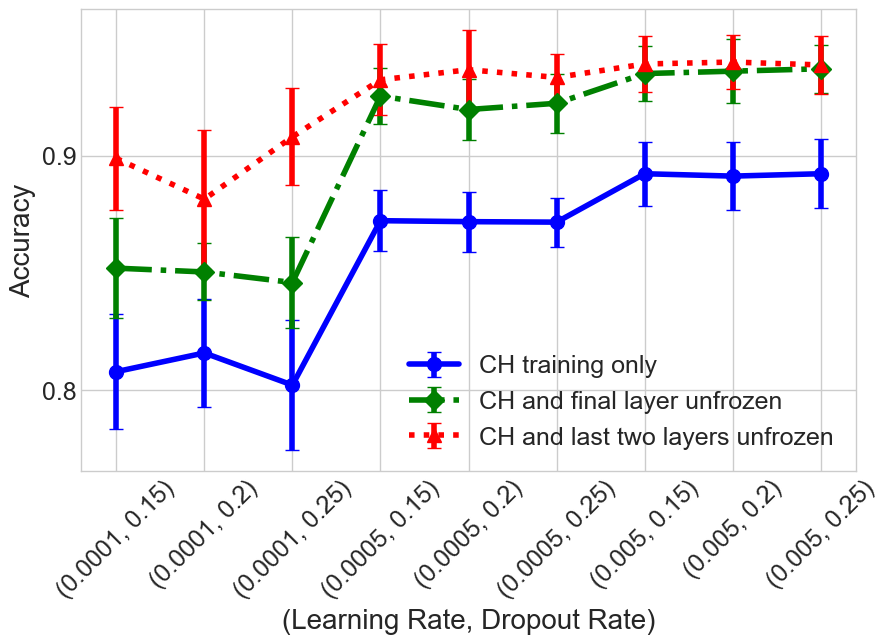

In [273]:
# Accuracy plot
plot_optimizer_results(results_data, 'SGD', metric='accuracy', metric_err='accuracy_std', modeling_type='training')

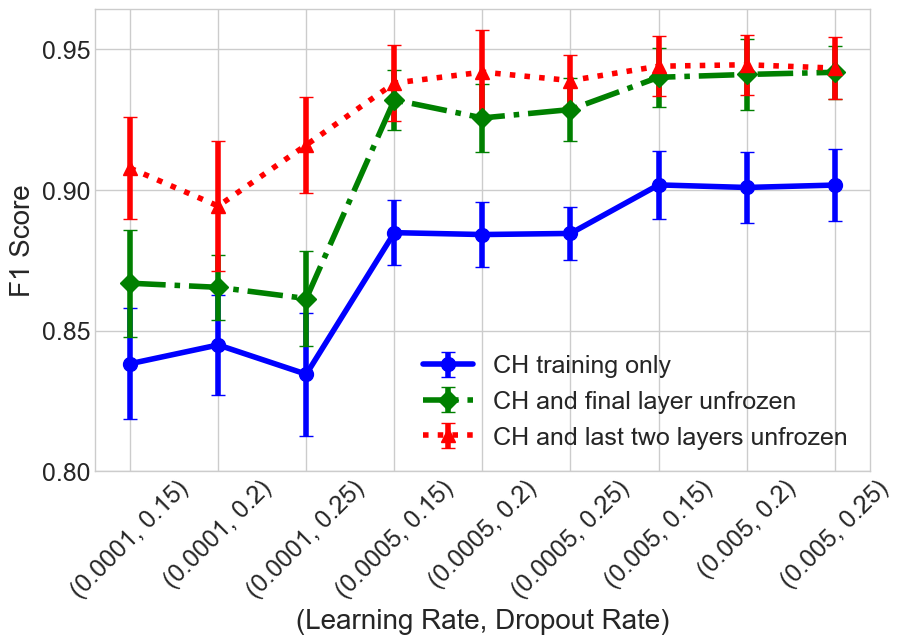

In [280]:
# F1 Score plot
plot_optimizer_results(results_data, 'SGD', metric='f1_score', metric_err='f1_score_std', 
    modeling_type='training', yaxisticks=[0.8, 0.96, 0.05])

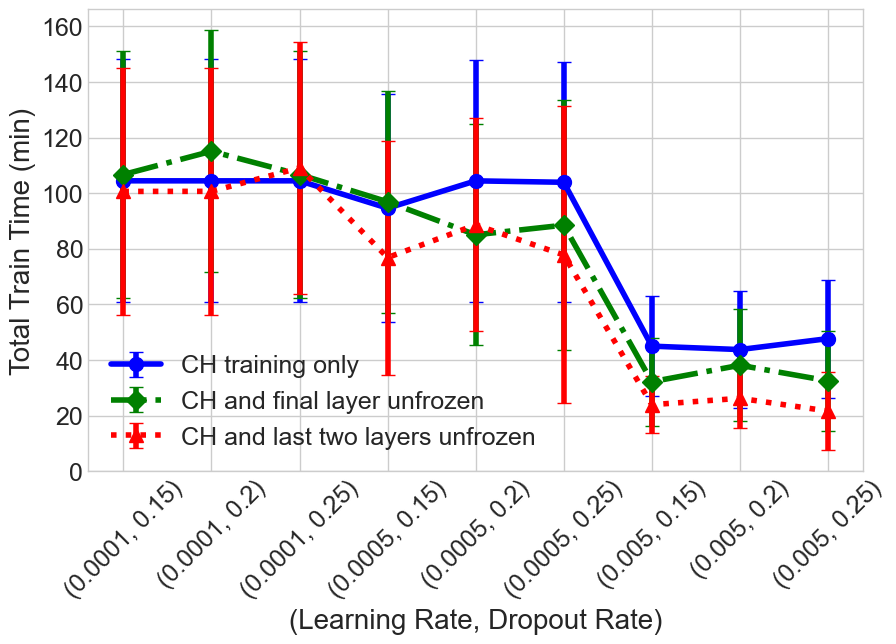

In [281]:
# Training time plot
plot_optimizer_results(train_time_data, 'SGD', metric='TrainingTimeMin', metric_err='TrainingTimeMinStd', 
    modeling_type='training',  yaxisticks=[0, 171, 20])

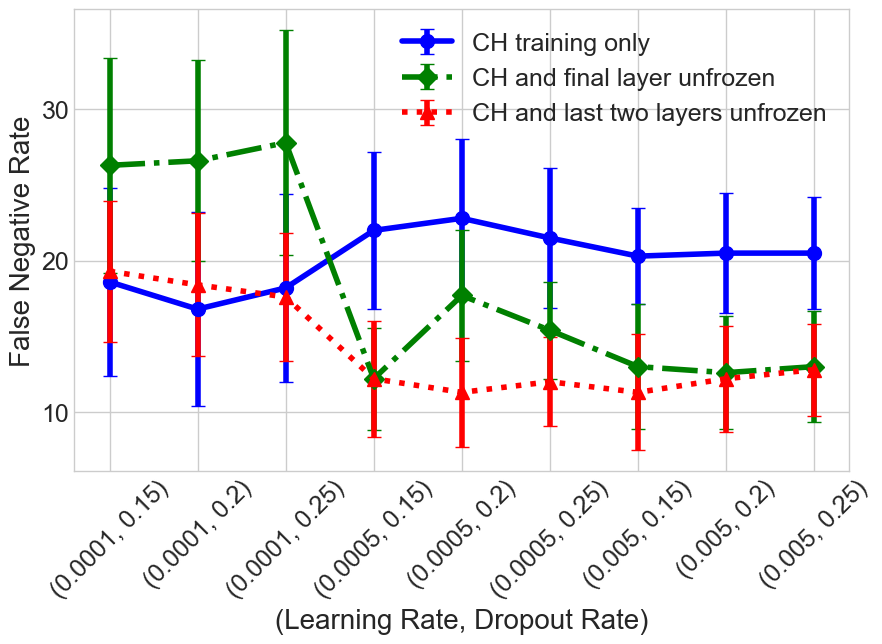

In [103]:
# Just need to have a look at the TF/TN/FP/FN for all the optimisers, not going to save the plots
plot_optimizer_results(results_data, 'SGD', metric='fn', metric_err='fn_std', flg_save=False)

For AdamW optimiser: 
* TP plot look very similar to the accuracy plot
* FP plot is reverse of accuracy -- NN1 has the highest values, followed by NN2 and then NN3. However, NN3 has much higher FP values for dropout = 0.005, and very large error bars
* TN plot similar to accuracy, however it looks like NN2 has slightly higher values than NN3. 
* FN plot is similar to FP plot


For Adam optimiser: 
* TP plot look quite different from accuracy -- NN3 has higher TP values for dropout=0.005 than NN2; the error bars are a lot bigger for all NNs
* FP reverse of accuracy -- cf AdamW. 
* TN plot similar to accuracy, with NN3 slightly higher than NN2 for lower dropouts. 
* FN plot is similar to FP plot, however NN3 doesnt look very different for dropout=0.005

For SGD optimiser: 
* TP plot is somewhat different from accuracy -- NN2 has lower TP values for dropout=0.0001 than NN1, whereas NN1 and NN3 has similar value; plot looks similar for the other drop out values
* FP plot is reverse of accuracy -- NN1 has the highest values, followed by NN2 and then NN3. This is reasonable since FP is not what we want. 
* TN plot similar to accuracy
* FN plot -- NN2 has higher values for dropout=0.0001 than NN1, otherwise the trend looks similar to FP plot. 


Generate a table of the top results for the paper, we'll just use the learning rates of 0.0001 and 0.0005, and the 3 dropout rates. For just CH + 2 unfrozen layers, for each optimizer. 

In [243]:
dataTable = train_time_data # link to the data table that we want to use: results_data or train_time_data
metricTable = 'TrainingTimeMin'  # Change this to 'accuracy', 'f1_score' or 'total_train_time_s' as needed
# If loop to map metricTable to the correct metric in the results_data
if metricTable == 'accuracy':
    metric = 'accuracy'
    metric_err = 'accuracy_std'
elif metricTable == 'f1_score':
    metric = 'f1_score'
    metric_err = 'f1_score_std'
elif metricTable == 'total_train_time_s':
    metric = 'total_train_time_s'
    metric_err = 'total_train_time_s_std'
elif metricTable == 'TrainingTimeMin':
    metric = 'TrainingTimeMin'
    metric_err = 'TrainingTimeMinStd'
else:
    raise ValueError("Invalid metric. Choose from 'accuracy', 'f1_score', or 'total_train_time_s'.")

dropouts = [0.15, 0.2, 0.25]
learning_rates = [0.0001, 0.0005]
combinations = list(itertools.product(learning_rates, dropouts))
columns = [f"({a}, {b})" for a, b in combinations]

# LaTeX table header
header = "Optimiser & " + " & ".join(columns) + " \\\\ \\midrule"

# Put the results into the LaTeX table format
rows = []
for optimizer in dataTable['optimiser'].unique():
    row = [optimizer]
    #optimizer_data = results_data[results_data['optimiser'] == optimizer]
    for a, b in combinations:
        match = dataTable[
            (dataTable['optimiser'] == optimizer) & 
            (dataTable['folder_lr'] == a) & 
            (dataTable['folder_dropout'] == b) & 
            (dataTable['folder_unf'] == 0)
        ]
        if not match.empty: 
            mean = match[metric].values[0]
            std = match[metric_err].values[0]
            value = f"${mean:.3f} \\pm {std:.3f}$"
        else:
            value = "--"
        row.append(value)
    rows.append(" & ".join(row) + " \\\\")

# Put the LaTeX table together
latex_table = "\\begin{table}[H]\n\\centering\n\\begin{tabular}{l" + "c" * len(columns) + "}\n"
latex_table += "\\toprule\n" + header + "\n"
latex_table += "\n".join(rows) + "\n"
latex_table += "\\bottomrule\n\\end{tabular}\n\\caption{}\n\\label{tab:}\n\\end{table}"

# Print the LaTeX table
print(latex_table)

\begin{table}[H]
\centering
\begin{tabular}{lcccccc}
\toprule
Optimiser & (0.0001, 0.15) & (0.0001, 0.2) & (0.0001, 0.25) & (0.0005, 0.15) & (0.0005, 0.2) & (0.0005, 0.25) \\ \midrule
Adam & $52.012 \pm 31.871$ & $54.622 \pm 36.095$ & $53.690 \pm 33.143$ & $24.953 \pm 11.361$ & $28.247 \pm 13.267$ & $29.620 \pm 12.057$ \\
AdamW & $60.175 \pm 36.935$ & $57.892 \pm 34.549$ & $58.152 \pm 35.111$ & $28.470 \pm 17.422$ & $30.002 \pm 21.738$ & $26.483 \pm 17.515$ \\
SGD & $104.448 \pm 43.670$ & $104.433 \pm 43.664$ & $104.443 \pm 43.626$ & $94.610 \pm 40.999$ & $104.432 \pm 43.617$ & $103.918 \pm 43.134$ \\
\bottomrule
\end{tabular}
\caption{}
\label{tab:}
\end{table}


## Prediction results using just the model trained on MIMIC data

In [138]:
pred_data = pd.read_csv('prediction_results.csv')

In [205]:
pred_time_data = pd.read_csv('../Outputs/predict_time_analysis.csv')
pred_time_data.head()

,optimiser,folder_lr,folder_dropout,folder_unf,PredictTimeSeconds,PredTimeStd,NumSeeds
0,Adam,0.0001,0.15,0,201.9,28.088946,10
1,Adam,0.0001,0.15,1,233.5,38.859433,10
2,Adam,0.0001,0.15,2,213.7,30.452331,10
3,Adam,0.0001,0.20,0,216.0,33.536050,10
4,Adam,0.0001,0.20,1,218.4,41.936990,10


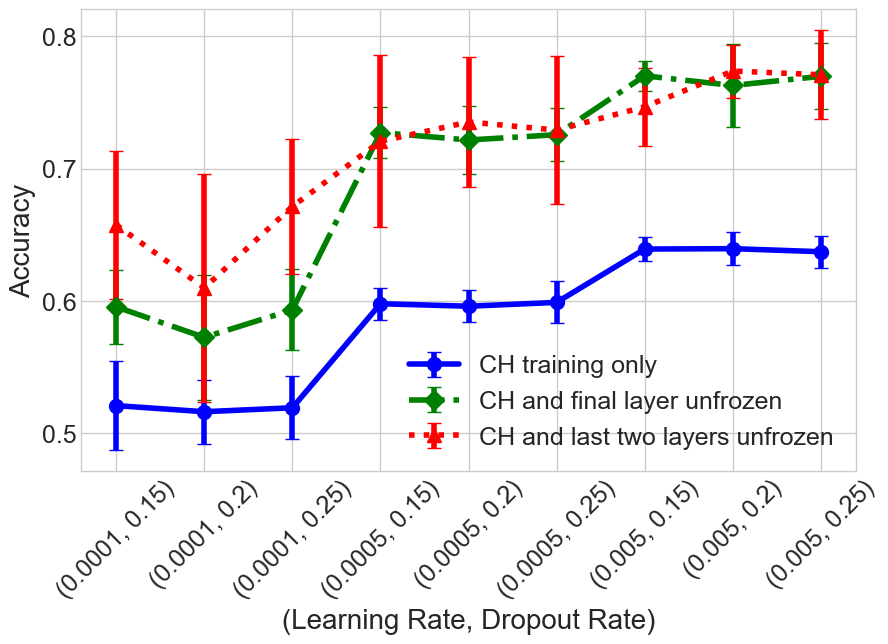

In [282]:
plot_optimizer_results(pred_data, 'SGD', metric='accuracy', metric_err='accuracy_std', modeling_type='prediction',  flg_save=True)

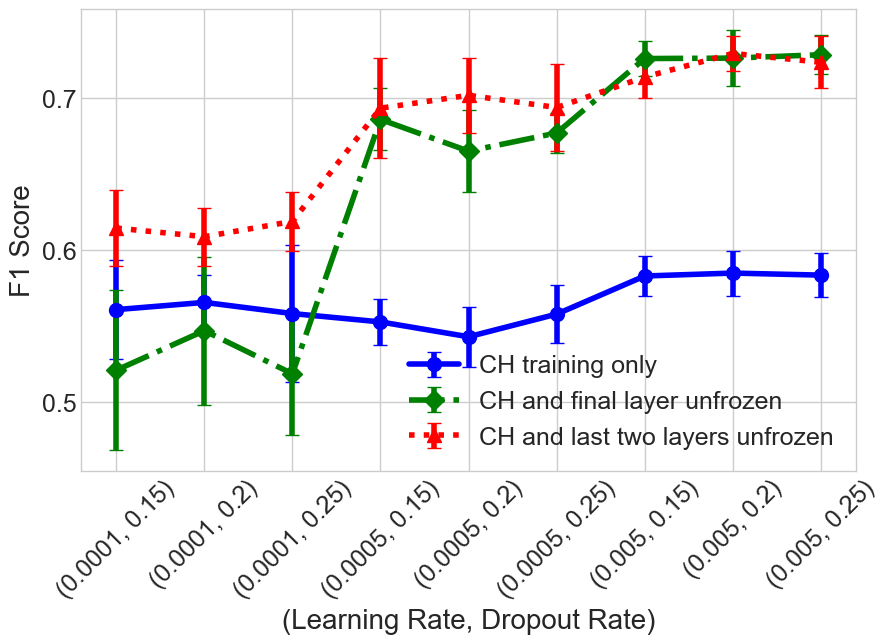

In [283]:
plot_optimizer_results(pred_data, 'SGD', metric='f1_score', metric_err='f1_score_std', modeling_type='prediction', flg_save=True)

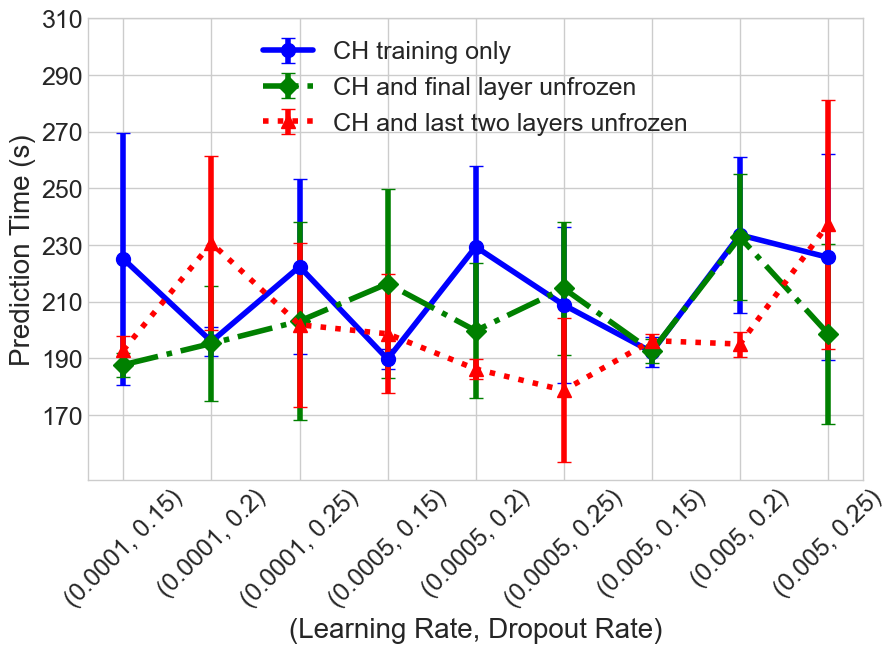

In [284]:
plot_optimizer_results(pred_time_data, 'SGD', metric='PredictTimeSeconds', metric_err='PredTimeStd', modeling_type='prediction', 
    yaxisticks=[170, 311, 20], flg_save=True)

Generate the table for results for the paper

In [247]:
metricTable = 'accuracy'  # Change this to 'accuracy', 'f1_score' or 'total_train_time_s' as needed
# If loop to map metricTable to the correct metric in the pred_data
if metricTable == 'accuracy':
    metric = 'accuracy'
    metric_err = 'accuracy_std'
elif metricTable == 'f1_score':
    metric = 'f1_score'
    metric_err = 'f1_score_std'
elif metricTable == 'total_train_time_s':
    metric = 'total_train_time_s'
    metric_err = 'total_train_time_s_std'
else:
    raise ValueError("Invalid metric. Choose from 'accuracy', 'f1_score', or 'total_train_time_s'.")

dropouts = [0.15, 0.2, 0.25]
learning_rates = [0.0001, 0.0005]
combinations = list(itertools.product(learning_rates, dropouts))
columns = [f"({a}, {b})" for a, b in combinations]

# LaTeX table header
header = "Optimiser & " + " & ".join(columns) + " \\\\ \\midrule"

# Put the results into the LaTeX table format
rows = []
for optimizer in pred_data['optimiser'].unique():
    row = [optimizer]
    for a, b in combinations:
        match = pred_data[
            (pred_data['optimiser'] == optimizer) & 
            (pred_data['folder_lr'] == a) & 
            (pred_data['folder_dropout'] == b) & 
            (pred_data['folder_unf'] == 0)
        ]
        if not match.empty: 
            mean = match[metric].values[0]
            std = match[metric_err].values[0]
            value = f"${mean:.3f} \\pm {std:.3f}$"
        else:
            value = "--"
        row.append(value)
    rows.append(" & ".join(row) + " \\\\")

# Put the LaTeX table together
latex_table = "\\begin{table}[H]\n\\centering\n\\begin{tabular}{l" + "c" * len(columns) + "}\n"
latex_table += "\\toprule\n" + header + "\n"
latex_table += "\n".join(rows) + "\n"
latex_table += "\\bottomrule\n\\end{tabular}\n\\caption{}\n\\label{tab:}\n\\end{table}"

# Print the LaTeX table
print(latex_table)

\begin{table}[H]
\centering
\begin{tabular}{lcccccc}
\toprule
Optimiser & (0.0001, 0.15) & (0.0001, 0.2) & (0.0001, 0.25) & (0.0005, 0.15) & (0.0005, 0.2) & (0.0005, 0.25) \\ \midrule
Adam & $0.672 \pm 0.008$ & $0.672 \pm 0.009$ & $0.673 \pm 0.007$ & $0.683 \pm 0.009$ & $0.682 \pm 0.004$ & $0.686 \pm 0.009$ \\
AdamW & $0.675 \pm 0.015$ & $0.682 \pm 0.011$ & $0.682 \pm 0.010$ & $0.695 \pm 0.012$ & $0.696 \pm 0.010$ & $0.693 \pm 0.008$ \\
SGD & $0.521 \pm 0.034$ & $0.516 \pm 0.024$ & $0.519 \pm 0.024$ & $0.598 \pm 0.012$ & $0.596 \pm 0.012$ & $0.599 \pm 0.016$ \\
\bottomrule
\end{tabular}
\caption{}
\label{tab:}
\end{table}


## Fine-tuning results

In [127]:
finetune_data = pd.read_csv("fine_tune_results.csv")

In [250]:
finetune_time_data = pd.read_csv('../Outputs/cpu_finetune_time_analysis.csv')
# convert the time to minutes
finetune_time_data['TrainingTimeMin'] = finetune_time_data['TrainingTimeSeconds'].astype(float) / 60
finetune_time_data['TrainingTimeMinStd'] = finetune_time_data['TrainingTimeStd'].astype(float) / 60

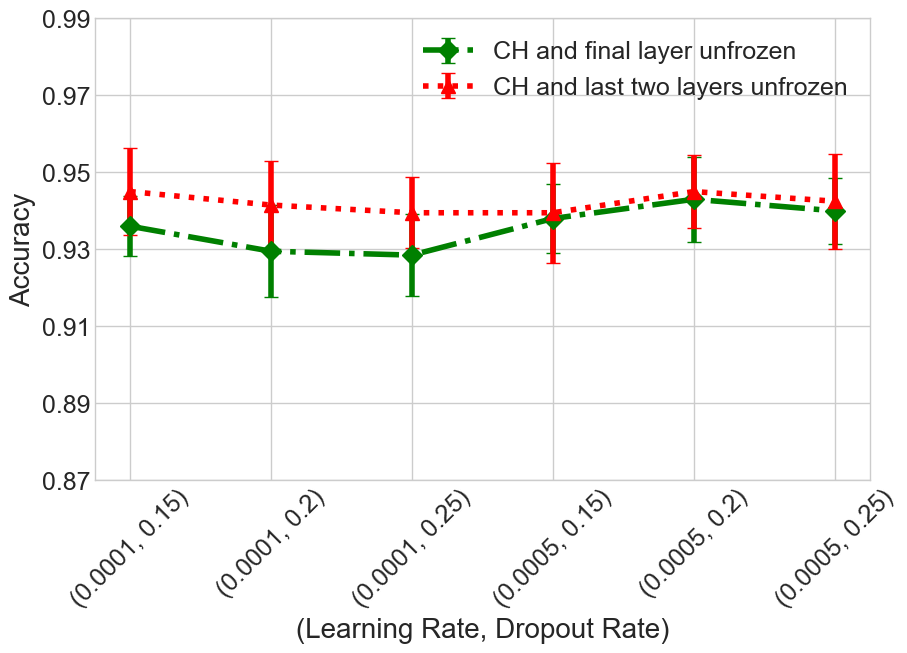

In [256]:
plot_optimizer_results(finetune_data, 'Adam', metric='accuracy', metric_err='accuracy_std', modeling_type='finetuning', yaxisticks=[0.87, 1.0, 0.02], flg_save=True)

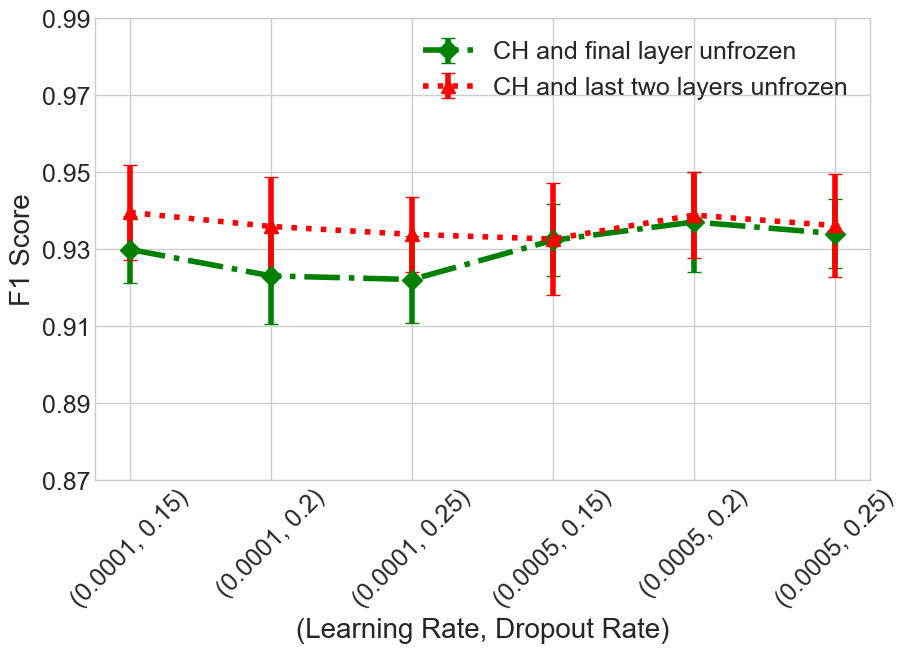

In [257]:
plot_optimizer_results(finetune_data, 'Adam', metric='f1_score', metric_err='f1_score_std', modeling_type='finetuning', yaxisticks=[0.87, 1.0, 0.02], flg_save=True)

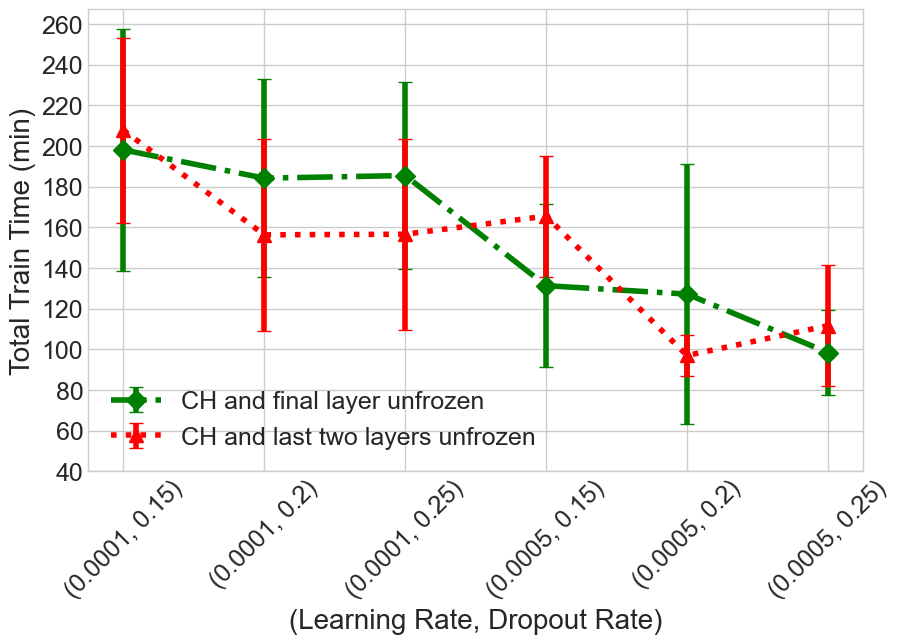

In [260]:
plot_optimizer_results(finetune_time_data, 'Adam', metric='TrainingTimeMin', metric_err='TrainingTimeMinStd', modeling_type='finetuning',
    yaxisticks=[40, 261, 20], flg_save=True)

Generate table for the paper

In [255]:
dataTable = finetune_time_data # link to the data table that we want to use: finetune_data or finetune_time_data
metricTable = 'TrainingTimeMin'  # Change this to 'accuracy', 'f1_score' or 'total_train_time_s' as needed
# If loop to map metricTable to the correct metric in the results_data
if metricTable == 'accuracy':
    metric = 'accuracy'
    metric_err = 'accuracy_std'
elif metricTable == 'f1_score':
    metric = 'f1_score'
    metric_err = 'f1_score_std'
elif metricTable == 'total_train_time_s':
    metric = 'total_train_time_s'
    metric_err = 'total_train_time_s_std'
elif metricTable == 'TrainingTimeMin':
    metric = 'TrainingTimeMin'
    metric_err = 'TrainingTimeMinStd'
else:
    raise ValueError("Invalid metric. Choose from 'accuracy', 'f1_score', or 'total_train_time_s'.")

dropouts = [0.15, 0.2, 0.25]
learning_rates = [0.0001, 0.0005]
combinations = list(itertools.product(learning_rates, dropouts))
columns = [f"({a}, {b})" for a, b in combinations]

# LaTeX table header
header = "Optimiser & " + " & ".join(columns) + " \\\\ \\midrule"

# Put the results into the LaTeX table format
rows = []
for optimizer in finetune_pred_data['optimiser'].unique():
    row = [optimizer]
    #optimizer_data = results_data[results_data['optimiser'] == optimizer]
    for a, b in combinations:
        match = dataTable[
            (dataTable['optimiser'] == optimizer) & 
            (dataTable['folder_lr'] == a) & 
            (dataTable['folder_dropout'] == b) & 
            (dataTable['folder_unf'] == 0)
        ]
        if not match.empty: 
            mean = match[metric].values[0]
            std = match[metric_err].values[0]
            value = f"${mean:.3f} \\pm {std:.3f}$"
        else:
            value = "--"
        row.append(value)
    rows.append(" & ".join(row) + " \\\\")

# Put the LaTeX table together
latex_table = "\\begin{table}[H]\n\\centering\n\\begin{tabular}{l" + "c" * len(columns) + "}\n"
latex_table += "\\toprule\n" + header + "\n"
latex_table += "\n".join(rows) + "\n"
latex_table += "\\bottomrule\n\\end{tabular}\n\\caption{}\n\\label{tab:}\n\\end{table}"

# Print the LaTeX table
print(latex_table)

\begin{table}[H]
\centering
\begin{tabular}{lcccccc}
\toprule
Optimiser & (0.0001, 0.15) & (0.0001, 0.2) & (0.0001, 0.25) & (0.0005, 0.15) & (0.0005, 0.2) & (0.0005, 0.25) \\ \midrule
Adam & -- & -- & -- & -- & -- & -- \\
AdamW & -- & -- & -- & -- & -- & -- \\
\bottomrule
\end{tabular}
\caption{}
\label{tab:}
\end{table}


## Prediction using fine-tuned models

In [172]:
finetune_pred_data = pd.read_csv("fine_tune_prediction_results.csv")

In [225]:
finetunePred_time_data = pd.read_csv('../Outputs/predict_finetune_time_analysis.csv')

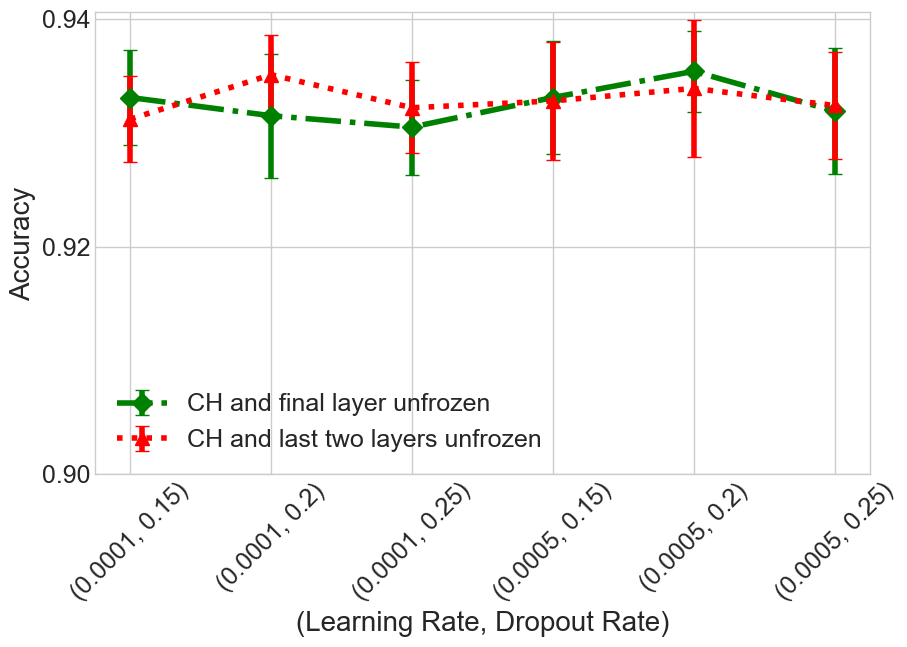

In [262]:
plot_optimizer_results(finetune_pred_data, 'Adam', metric='accuracy', metric_err='accuracy_std', modeling_type='finetune_prediction', yaxisticks=[0.90,0.96,0.02], flg_save=True)

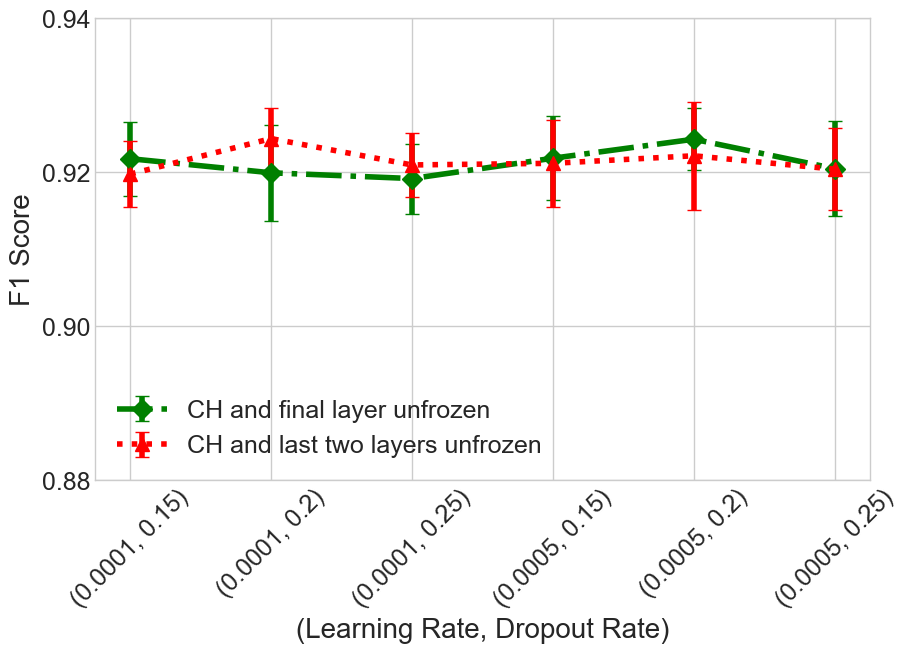

In [263]:
plot_optimizer_results(finetune_pred_data, 'Adam', metric='f1_score', metric_err='f1_score_std', modeling_type='finetune_prediction', yaxisticks=[0.88,0.96,0.02], flg_save=True)

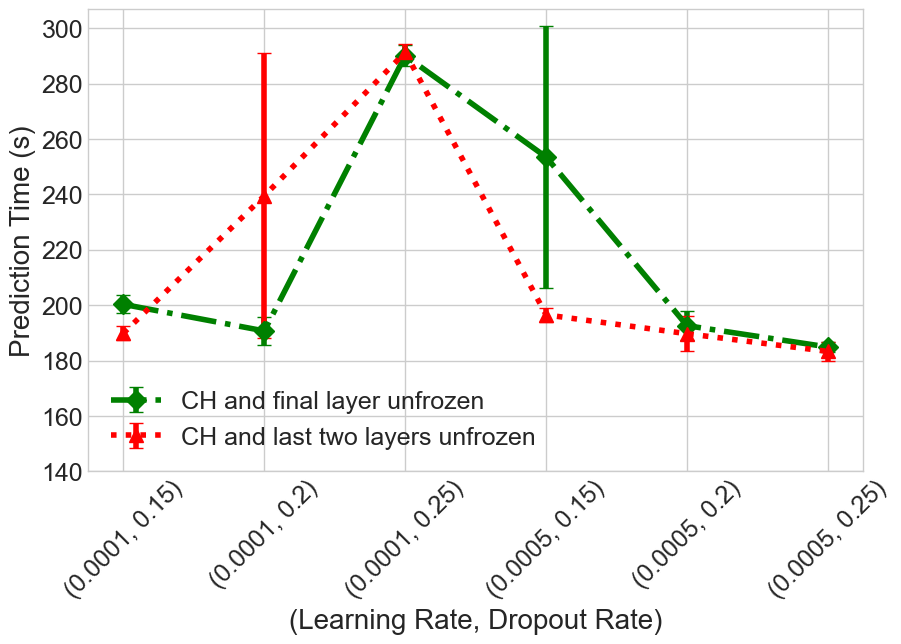

In [264]:
plot_optimizer_results(finetunePred_time_data, 'Adam', metric='PredictTimeSeconds', metric_err='PredictTimeStd', modeling_type='finetune_prediction', 
    yaxisticks=[140, 301, 20], flg_save=True)

Generate LaTex table for the paper

In [267]:
metricTable = 'f1_score'  # Change this to 'accuracy', 'f1_score' or 'total_train_time_s' as needed
# If loop to map metricTable to the correct metric in the results_data
if metricTable == 'accuracy':
    metric = 'accuracy'
    metric_err = 'accuracy_std'
elif metricTable == 'f1_score':
    metric = 'f1_score'
    metric_err = 'f1_score_std'
elif metricTable == 'total_train_time_s':
    metric = 'total_train_time_s'
    metric_err = 'total_train_time_s_std'
else:
    raise ValueError("Invalid metric. Choose from 'accuracy', 'f1_score', or 'total_train_time_s'.")

dropouts = [0.15, 0.2, 0.25]
learning_rates = [0.0001, 0.0005]
combinations = list(itertools.product(learning_rates, dropouts))
columns = [f"({a}, {b})" for a, b in combinations]

# LaTeX table header
header = "Optimiser & " + " & ".join(columns) + " \\\\ \\midrule"

# Put the results into the LaTeX table format
rows = []
for optimizer in finetune_pred_data['optimiser'].unique():
    row = [optimizer]
    #optimizer_data = results_data[results_data['optimiser'] == optimizer]
    for a, b in combinations:
        match = finetune_pred_data[
            (finetune_pred_data['optimiser'] == optimizer) & 
            (finetune_pred_data['folder_lr'] == a) & 
            (finetune_pred_data['folder_dropout'] == b) & 
            (finetune_pred_data['folder_unf'] == 1)
        ]
        if not match.empty: 
            mean = match[metric].values[0]
            std = match[metric_err].values[0]
            value = f"${mean:.3f} \\pm {std:.3f}$"
        else:
            value = "--"
        row.append(value)
    rows.append(" & ".join(row) + " \\\\")

# Put the LaTeX table together
latex_table = "\\begin{table}[H]\n\\centering\n\\begin{tabular}{l" + "c" * len(columns) + "}\n"
latex_table += "\\toprule\n" + header + "\n"
latex_table += "\n".join(rows) + "\n"
latex_table += "\\bottomrule\n\\end{tabular}\n\\caption{}\n\\label{tab:}\n\\end{table}"

# Print the LaTeX table
print(latex_table)

\begin{table}[H]
\centering
\begin{tabular}{lcccccc}
\toprule
Optimiser & (0.0001, 0.15) & (0.0001, 0.2) & (0.0001, 0.25) & (0.0005, 0.15) & (0.0005, 0.2) & (0.0005, 0.25) \\ \midrule
Adam & $0.922 \pm 0.005$ & $0.920 \pm 0.006$ & $0.919 \pm 0.005$ & $0.922 \pm 0.005$ & $0.924 \pm 0.004$ & $0.920 \pm 0.006$ \\
AdamW & $0.913 \pm 0.007$ & $0.911 \pm 0.005$ & $0.911 \pm 0.007$ & $0.918 \pm 0.004$ & $0.919 \pm 0.006$ & $0.916 \pm 0.006$ \\
\bottomrule
\end{tabular}
\caption{}
\label{tab:}
\end{table}


## Time with different CPU numbers

I ran AdamW (lr = 0.0001, dropout = 0.15), unfreeze = 1, on different number of CPUs to see how fast the code runs when given more than one CPU. The times are what the `sacct` report give me. 

In [11]:
# function to plot the average and std of the time for one set of data
def plot_time_analysis(data, metric, metric_err, yaxisticks = [], modeling_type = 'training'):
    """
    Function to plot the average and std of the time for one set of data.
    
    Parameters:
    - data: DataFrame containing the results data
    - metric: string, name of the metric to plot
    - metric_err: string, name of the error metric to plot
    - modeling_type: string, type of modeling (e.g., 'training', 'prediction')
    """

    # Set the figure size
    plt.figure(figsize=(10, 6))

    # plot the data
    plt.errorbar(data['CPU_Count'], data[metric], yerr=data[metric_err],
                 marker='o', color='blue', linestyle='-', linewidth=4,
                 capsize=5, elinewidth=4, 
                 markeredgewidth=1, markersize=10)

    # Set the x and y axis labels
    plt.xlabel('CPU Count')
    if metric == 'avg_elapsed_time_s': 
        plt.ylabel('Total Run Time (s)')
    elif metric == 'RunTimeMin':
        plt.ylabel('Total Run Time (min)')
    else:
        raise ValueError("Invalid metric. Choose from 'avg_elapsed_time_s' or 'RunTimeMin'.")
    # if yaxisticks is not empty, set the y axis ticks
    if yaxisticks:
        plt.yticks(ticks=np.arange(yaxisticks[0], yaxisticks[1], yaxisticks[2]))
    
    # save the plot
    plt.savefig(f'CPUNumb_{modeling_type}_{metric}.png', dpi=300, bbox_inches='tight')

### fine-tuning the networks

In [10]:
time_finetune_cpu = pd.read_csv('time_finetune_diffCPU_AdamW_lr0.0001_dr0.15_unf1.csv')
time_finetune_cpu['RunTimeMin'] = time_finetune_cpu['avg_elapsed_time_s'].astype(float) / 60
time_finetune_cpu['RunTimeMinStd'] = time_finetune_cpu['std_elapsed_time'].astype(float) / 60

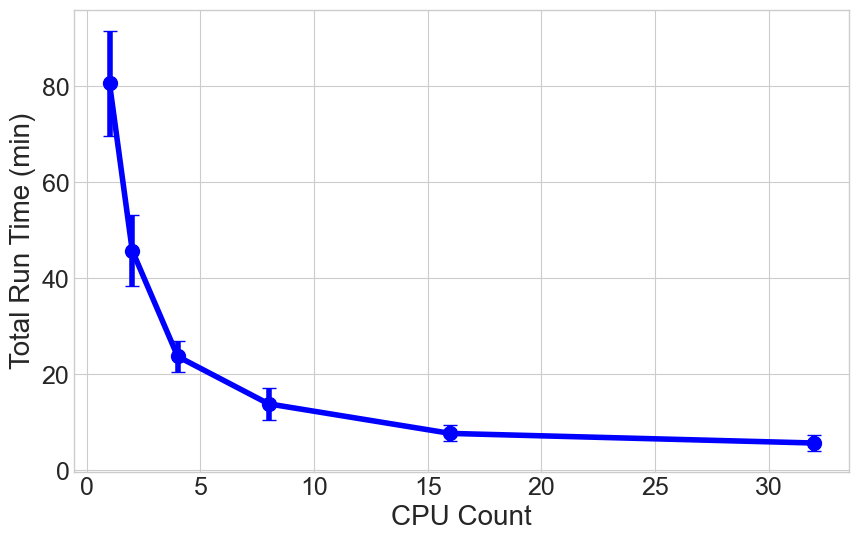

In [13]:
plot_time_analysis(time_finetune_cpu, 'RunTimeMin', 'RunTimeMinStd',
    yaxisticks=[0, 100, 20], modeling_type='finetuning')

### Prediction with fine-tuned models

In [17]:
time_finetunePred_cpu = pd.read_csv('time_finetune_pred_diffCPU_AdamW_lr0.0001_dr0.15_unf1.csv')

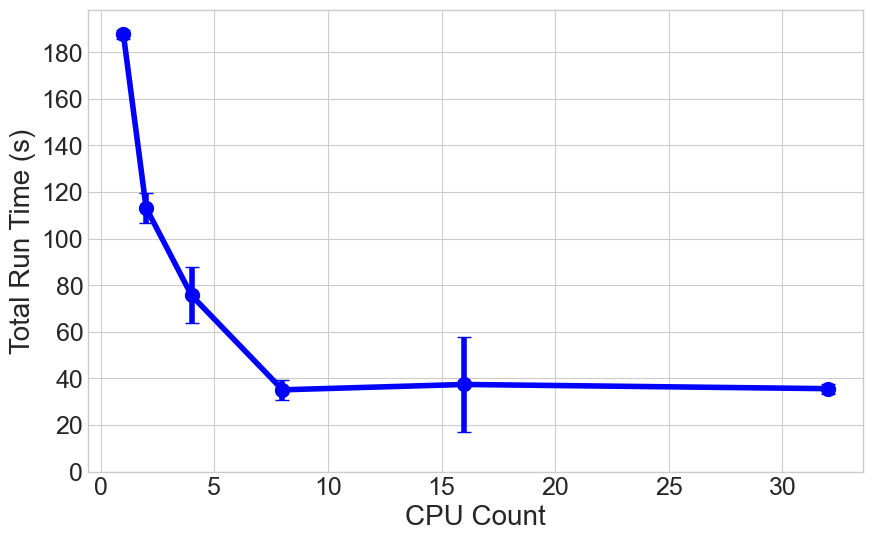

In [18]:
plot_time_analysis(time_finetunePred_cpu, 'avg_elapsed_time_s', 'std_elapsed_time',
    yaxisticks=[0, 200, 20], modeling_type='finetuning_prediction')